In [3]:
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]
train_dir = "Datasets/Train"
valid_dir = "Datasets/Test"

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 subset="training",
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_dir,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')


trainStepSize=training_set.n//training_set.batch_size
testStepSize=test_set.n//test_set.batch_size

Found 240 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


In [5]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=True)

 

# Using Adam optimiser

In [4]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=True)
for layer in vgg.layers[:22]:
 layer.trainable = False
 
x = vgg.get_layer('fc2').output
x=Dropout(0.5)(x)
prediction = Dense(6, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [5]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)
callbacks = [checkpoint, lr_reducer]

In [6]:
history = model.fit_generator(training_set, 
                    steps_per_epoch=trainStepSize, 
                    epochs = 5, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
30/30 [==============================] - 22s 724ms/step - loss: 2.2679 - accuracy: 0.2583
Epoch 2/5
30/30 [==============================] - 22s 727ms/step - loss: 1.3622 - accuracy: 0.5042
Epoch 3/5
30/30 [==============================] - 22s 733ms/step - loss: 0.8709 - accuracy: 0.6667
Epoch 4/5
30/30 [==============================] - 22s 734ms/step - loss: 0.8081 - accuracy: 0.6917
Epoch 5/5
30/30 [==============================] - 22s 725ms/step - loss: 0.6587 - accuracy: 0.7583


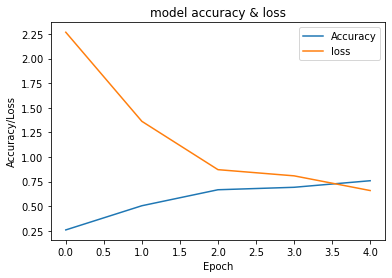

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy','loss'])
plt.show()

In [8]:
score = model.evaluate(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 9s 1s/step - loss: 0.3221 - accuracy: 0.9000
Test Loss: 0.3220777213573456
Test accuracy: 0.8999999761581421


# Using RMSPROP optimiser

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
30/30 [==============================] - 21s 705ms/step - loss: 2.2665 - accuracy: 0.2958
Epoch 2/5
30/30 [==============================] - 22s 745ms/step - loss: 1.4626 - accuracy: 0.4708
Epoch 3/5
30/30 [==============================] - 22s 746ms/step - loss: 1.2164 - accuracy: 0.5500
Epoch 4/5
30/30 [==============================] - 22s 729ms/step - loss: 0.8224 - accuracy: 0.7083
Epoch 5/5
30/30 [==============================] - 22s 720ms/step - loss: 0.7271 - accuracy: 0.7625


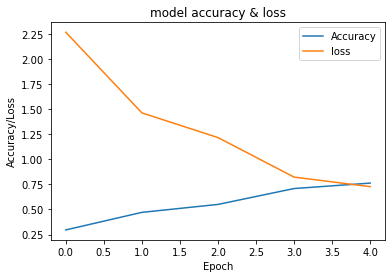

8/8 [==============================] - 9s 1s/step - loss: 0.5494 - accuracy: 0.7917
Test Loss: 0.5494356751441956
Test accuracy: 0.7916666865348816


In [6]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=True)
for layer in vgg.layers[:22]:
 layer.trainable = False
 
x = vgg.get_layer('fc2').output
x=Dropout(0.5)(x)
prediction = Dense(6, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer='rmsprop',
                    metrics=['accuracy'])
#model.summary()
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)
callbacks = [checkpoint, lr_reducer]
history = model.fit_generator(training_set, 
                    steps_per_epoch=trainStepSize, 
                    epochs = 5, verbose=1)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy','loss'])
plt.show()
score = model.evaluate(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

# Using Adagrad Optimiser

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
30/30 [==============================] - 22s 744ms/step - loss: 2.1258 - accuracy: 0.2125
Epoch 2/5
30/30 [==============================] - 23s 767ms/step - loss: 1.8825 - accuracy: 0.3000
Epoch 3/5
30/30 [==============================] - 23s 750ms/step - loss: 1.7306 - accuracy: 0.3542
Epoch 4/5
30/30 [==============================] - 22s 726ms/step - loss: 1.6853 - accuracy: 0.3083
Epoch 5/5
30/30 [==============================] - 22s 733ms/step - loss: 1.6435 - accuracy: 0.3417


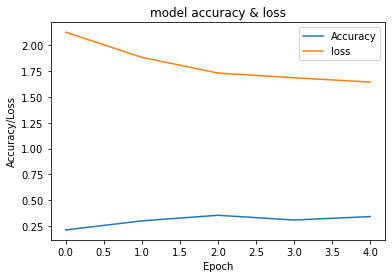

8/8 [==============================] - 9s 1s/step - loss: 1.1236 - accuracy: 0.7333
Test Loss: 1.1236233711242676
Test accuracy: 0.7333333492279053


In [6]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=True)
for layer in vgg.layers[:22]:
 layer.trainable = False
 
x = vgg.get_layer('fc2').output
x=Dropout(0.5)(x)
prediction = Dense(6, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adagrad(),
                    metrics=['accuracy'])
#model.summary()
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)
callbacks = [checkpoint, lr_reducer]
history = model.fit_generator(training_set, 
                    steps_per_epoch=trainStepSize, 
                    epochs = 5, verbose=1)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy','loss'])
plt.show()
score = model.evaluate(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])